# Lab 3 — dimensionality reduction

## Setup

In [4]:
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from operator import itemgetter

from pyspark.sql import SQLContext, Row
from pyspark.sql.types import *
from pyspark.mllib.linalg.distributed import RowMatrix, CoordinateMatrix, MatrixEntry

from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool

In [5]:
%matplotlib inline
plt.style.use("ggplot")

output_notebook()

sqlContext = SQLContext(sc)

Loading BokehJS ...

In [6]:
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 5

{"tagId": 1124, "tag": "writing"}
{"tagId": 1125, "tag": "wuxia"}
{"tagId": 1126, "tag": "wwii"}
{"tagId": 1127, "tag": "zombie"}
{"tagId": 1128, "tag": "zombies"}


In [7]:
!hdfs dfs -cat /ix/ml-20m/genome-scores.txt | tail -n 5

{"relevance": 0.58775, "tagId": 1124, "movieId": 131170}
{"relevance": 0.010749999999999982, "tagId": 1125, "movieId": 131170}
{"relevance": 0.015749999999999986, "tagId": 1126, "movieId": 131170}
{"relevance": 0.11449999999999999, "tagId": 1127, "movieId": 131170}
{"relevance": 0.02174999999999999, "tagId": 1128, "movieId": 131170}


In [8]:
data = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
dataS = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)

## Exercise 3.1

In [9]:
tag2name = dict(data.map(itemgetter("tagId", "tag")).collect())
tagIds = data.map(lambda x: int(x["tagId"])).distinct()
M = tagIds.max()

In [10]:
movieIds = dataS.map(lambda x: int(x["movieId"])).distinct()
movieIds_sorted = sorted(movieIds.collect())
N = movieIds.count()

In [11]:
scores = dataS.map(lambda r: Row(movieId=r.get("movieId"), tagId=r.get("tagId"), relevance=r.get("relevance")))
schemaScores = sqlContext.createDataFrame(scores)
schemaScores.registerTempTable("scores")

In [22]:
trans = {x: i for i, x in enumerate(movieIds_sorted)}

In [23]:
idx = dataS.map(lambda x: (x.get('tagId') - 1, trans[x.get('movieId')], x.get('relevance')))

In [28]:
dat = np.empty((M,N))
it = 0

for row in idx.collect():
    dat[row[0], row[1]] = row[2]
    
print(dat)

[[ 0.025    0.03975  0.0435  ...,  0.042    0.05975  0.05325]
 [ 0.025    0.04375  0.05475 ...,  0.03175  0.10375  0.08625]
 [ 0.05775  0.03775  0.028   ...,  0.017    0.1785   0.017  ]
 ..., 
 [ 0.03625  0.01475  0.0195  ...,  0.0095   0.51925  0.01575]
 [ 0.07775  0.09025  0.097   ...,  0.0755   0.067    0.1145 ]
 [ 0.023    0.01875  0.0185  ...,  0.01625  0.01725  0.02175]]


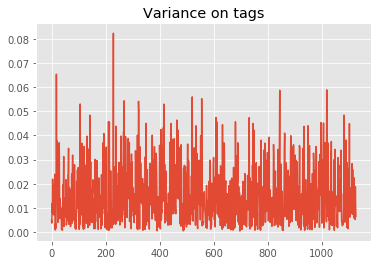

In [29]:
variances = dat.var(axis=1)
plt.plot(variances)
plt.title("Variance on tags")
plt.show()

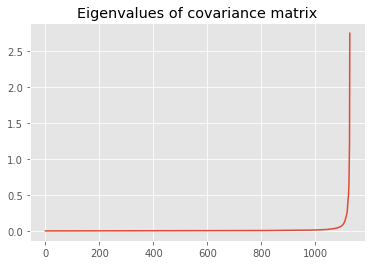

In [30]:
cov_mat = np.cov(dat)
eig_val, eig_vec = np.linalg.eigh(cov_mat)
plt.plot(eig_val)
plt.title("Eigenvalues of covariance matrix")
plt.show()

In [31]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val[i]), eig_vec[:,i]) for i in range(len(eig_val))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

## Exercise 3.2

In [32]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(1128,1), eig_pairs[1][1].reshape(1128,1)))
print('Matrix W:\n', matrix_w)

Matrix W:
 [[-0.00572728 -0.01383799]
 [-0.00478882 -0.01048045]
 [ 0.01246704  0.00278201]
 ..., 
 [ 0.01719115 -0.00551248]
 [-0.01026643 -0.01417361]
 [-0.00137267 -0.00551606]]


In [34]:
transformed = matrix_w.T.dot(dat)
transformed.shape

(2, 10381)

## Exercise 3.3

In [35]:
with open("selected-movies.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")

In [40]:
ids = list(map(lambda x: movieIds_sorted.index(x), map(itemgetter(0), movies)))
projected = transformed[:, ids]

In [41]:
def get_color(x):
    if x < 0.25:
        return "#0000FF"
    elif x < 0.5:
        return "#00FF00"
    elif x < 0.75:
        return "#FF0000"
    else:
        return "#FFFF00"

In [42]:
source = ColumnDataSource(
    data={
        "x": projected[0, :],
        "y": projected[1, :],
        "name": [x[1] for x in movies],
        "color": [get_color(x[2]) for x in movies],
    })
hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

In [43]:
p = figure(plot_width=960, tools=tools)
p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
show(p, notebook_handle=True)